# Sparkify Project

Sparkify is a fake music streaming service invented by Udacity. Here users can listen to music for free (with ads between songs) or for a flat fee. Users can upgrade, downgrade, or cancel. My task is to predict the user who is going to leave in order to offer him a great discount before canceling the subscription.

In [1]:
#checking memory

spark.sparkContext.getConf().get('spark.driver.memory')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
4,application_1611345580953_0005,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'11171M'

In [2]:
# We need to install pandas, matplotlib and seaborn
# Amazon EMR doesn't have these packages by default

sc.install_pypi_package("pandas", "https://pypi.org/simple") #Install pandas
sc.install_pypi_package("matplotlib", "https://pypi.org/simple") #Install matplotlib from given PyPI repository
sc.install_pypi_package("seaborn", "https://pypi.org/simple") #Install seaborn from given PyPI repository

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/7a/c2/339e302d4122cb8b166aecc823afed4af6b2193f040f2656eea77d174146/pandas-1.2.1-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/30/f2/10c822cb0ca5ebec58bd1892187bc3e3db64a867ac26531c6204663fc218/matplotlib-3.3.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/eb/8e/d2f7a67cf8da9b83c1e3ee38dbf49448f3c8acb2cb38f76e4301f4a70223/Pillow-8.1.0-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using ca

In [3]:
# Create spark session
# import libraries
import datetime
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, col, concat, count, lit, avg, lag, first, last, when
from pyspark.sql.functions import min as Fmin, max as Fmax, sum as Fsum, round as Fround

from pyspark.sql.types import IntegerType, DateType, TimestampType, StringType

from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Spark Session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Read in full sparkify dataset
# small dataset
#path = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
# big dataset
path = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(path)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# dataset schema
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [7]:
print("The number of rows is {}".format(df.count()))
print("The number of columns is {}".format(len(df.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The number of rows is 26259199
The number of columns is 18

In [8]:
# Number of duplicates
df.count() - df.dropDuplicates().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

First of all, les't convert the timestamps into datetime format and add them to the dataframe, for a clearer understanding.

In [9]:
# convert the timestamps into datetime format and add them to the dataframe, for a clearer understanding

df = df.withColumn('registrationDate', (df['registration'] / 1000).cast(TimestampType()))
df = df.withColumn('tsDate', (df['ts'] / 1000).cast(TimestampType()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
df.select('userId', 'page', 'song', 'ts', 'tsDate').sort('ts').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------+--------------------+-------------+-------------------+
| userId|    page|                song|           ts|             tsDate|
+-------+--------+--------------------+-------------+-------------------+
|1694515|NextSong|Give It Up (Album...|1538352001000|2018-10-01 00:00:01|
|1749042|NextSong|Ich mache einen S...|1538352001000|2018-10-01 00:00:01|
|1484921|NextSong|          Just Dance|1538352001000|2018-10-01 00:00:01|
|1563081|NextSong|         MiÃÂ©ntele|1538352002000|2018-10-01 00:00:02|
|1697168|NextSong|           Baby Talk|1538352002000|2018-10-01 00:00:02|
|1714398|NextSong|Close To The Edge...|1538352003000|2018-10-01 00:00:03|
|1222580|NextSong|Horn Concerto No....|1538352003000|2018-10-01 00:00:03|
|1379661|NextSong|All Along The Wat...|1538352003000|2018-10-01 00:00:03|
|1252007|    Home|                null|1538352003000|2018-10-01 00:00:03|
|1010522|NextSong|       Electric Feel|1538352004000|2018-10-01 00:00:04|
+-------+--------+--------------------

In [11]:
df.select('userId', 'page', 'song', 'ts', 'tsDate').sort('ts', ascending = False).show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+--------------------+-------------+-------------------+
| userId|           page|                song|           ts|             tsDate|
+-------+---------------+--------------------+-------------+-------------------+
|1761748|       NextSong|               TÃÂº|1543622402000|2018-12-01 00:00:02|
|1146733|Add to Playlist|                null|1543622400000|2018-12-01 00:00:00|
|1623507|       NextSong|The Way You Do Th...|1543622399000|2018-11-30 23:59:59|
|1245611|       NextSong|                Ho's|1543622399000|2018-11-30 23:59:59|
|1415761|       NextSong|Samba De Una Nota...|1543622398000|2018-11-30 23:59:58|
|1934208|       NextSong|Sommarnatt (Kom I...|1543622398000|2018-11-30 23:59:58|
|1024500|       NextSong|           Thickness|1543622398000|2018-11-30 23:59:58|
|1112854|       NextSong|Cae La Noche En O...|1543622397000|2018-11-30 23:59:57|
|1222603|         Logout|                null|1543622397000|2018-11-30 23:59:57|
|1793178|       NextSong|   

As mentioned above, observation period in full dataset from 00:00:01, October 01 to 23:59:59 November 30, 2018. The data set contains several records, which are out of the general set. Let's delete it:

In [12]:
# Remove rows with corrupted timestamps
df = df.where(df.ts <= 1543622399000)
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259197

Then analyse a partial dataset to get an idea of the dataframe.

#### 1. User-level information

User information such as first name, last name, location. And also the level that can be changed.

In [13]:
df.select(['userId', 'firstName', 'lastName', 'gender', 'location', 'registration', 'registrationDate', 'userAgent', 'level']).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+--------+------+--------------------+-------------+-------------------+--------------------+-----+
| userId|firstName|lastName|gender|            location| registration|   registrationDate|           userAgent|level|
+-------+---------+--------+------+--------------------+-------------+-------------------+--------------------+-----+
|1749042|    Shlok| Johnson|     M|Dallas-Fort Worth...|1533734541000|2018-08-08 13:22:21|"Mozilla/5.0 (Win...| paid|
|1563081|  Vianney|  Miller|     F|San Francisco-Oak...|1537500318000|2018-09-21 03:25:18|"Mozilla/5.0 (Mac...| paid|
|1697168|     Vina|  Bailey|     F|            Hilo, HI|1536414505000|2018-09-08 13:48:25|Mozilla/5.0 (Maci...| paid|
|1222580|   Andres|   Foley|     M|       Watertown, SD|1534386660000|2018-08-16 02:31:00|"Mozilla/5.0 (Mac...| paid|
|1714398|  Aaliyah| Ramirez|     F|Baltimore-Columbi...|1537381415000|2018-09-19 18:23:35|"Mozilla/5.0 (Win...| paid|
+-------+---------+--------+------+--------------------+

In [14]:
# Number of unique users in the dataset
print("Number of unique users is {}".format(df.select(['userId']).dropDuplicates().count()))
# Number of missing values in the 'userId' column
print("Number of missing values in the 'userId' column is {}".format(df.where(df.userId.isNull()).count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of unique users is 22278
Number of missing values in the 'userId' column is 0

In [15]:
# Rows with empty strings in the 'userId' column.
df.where(df.userId == "").count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In [16]:
df.where(df.userId == "").select(['userId', 'firstName', 'lastName', 'gender', 'location', 'registration', 'userAgent', 'level', 'tsDate', 'page', 'auth',]).show(10)
df.where(df.userId == "").groupby('auth').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------+--------+------+--------+------------+---------+-----+------+----+----+
|userId|firstName|lastName|gender|location|registration|userAgent|level|tsDate|page|auth|
+------+---------+--------+------+--------+------------+---------+-----+------+----+----+
+------+---------+--------+------+--------+------------+---------+-----+------+----+----+

+----+-----+
|auth|count|
+----+-----+
+----+-----+

Rows with an empty string in the 'userId' column correspond to logs in which the user has not been logged in ('Logged Out' or 'Guest'). An interesting observation is that there are no such lines in a large set.

#### 2. Log-specific information

Information about how different users interact with the music streaming service.

In [17]:
#  Log-specific information
df.select(['ts', 'tsDate', 'page', 'auth', 'sessionId', 'itemInSession', 'method', 'status']).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-------------------+--------+---------+---------+-------------+------+------+
|           ts|             tsDate|    page|     auth|sessionId|itemInSession|method|status|
+-------------+-------------------+--------+---------+---------+-------------+------+------+
|1538352001000|2018-10-01 00:00:01|NextSong|Logged In|    22683|          278|   PUT|   200|
|1538352002000|2018-10-01 00:00:02|NextSong|Logged In|    20836|            9|   PUT|   200|
|1538352002000|2018-10-01 00:00:02|NextSong|Logged In|     4593|          109|   PUT|   200|
|1538352003000|2018-10-01 00:00:03|NextSong|Logged In|     6370|           71|   PUT|   200|
|1538352003000|2018-10-01 00:00:03|NextSong|Logged In|    22316|           21|   PUT|   200|
+-------------+-------------------+--------+---------+---------+-------------+------+------+
only showing top 5 rows

In [18]:
print("Number of missing values in the 'page' column is {}".format(df.where(df.page.isNull()).count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of missing values in the 'page' column is 0

In [19]:
# pages types

pages_num = df.select('page').dropDuplicates().count()
df.select('page').dropDuplicates().show(pages_num)
print("Number of user actions is {}".format(pages_num))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                page|
+--------------------+
|           Downgrade|
|       Save Settings|
|               Error|
|     Add to Playlist|
|                Help|
|      Submit Upgrade|
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|         Roll Advert|
|               About|
|             Upgrade|
|Cancellation Conf...|
| Submit Registration|
|               Login|
|            Register|
|            NextSong|
|           Thumbs Up|
|              Logout|
|            Settings|
|          Add Friend|
+--------------------+

Number of user actions is 22

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

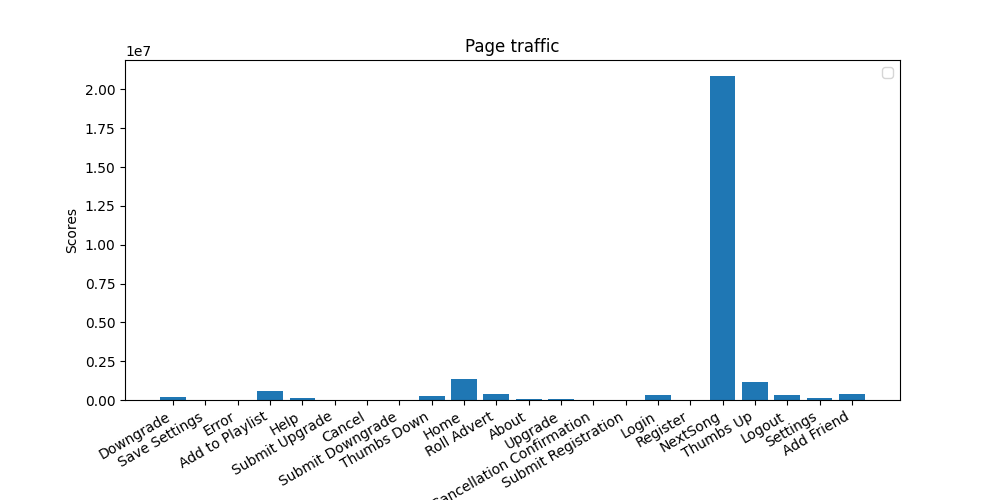

In [20]:
# plotting most often uses pages

pages_df = df.groupby('page').count().toPandas()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(pages_df['page'], pages_df['count'])
ax.set_ylabel('Scores')
ax.set_title('Page traffic')
ax.legend()
fig.autofmt_xdate()

plt.show()

%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

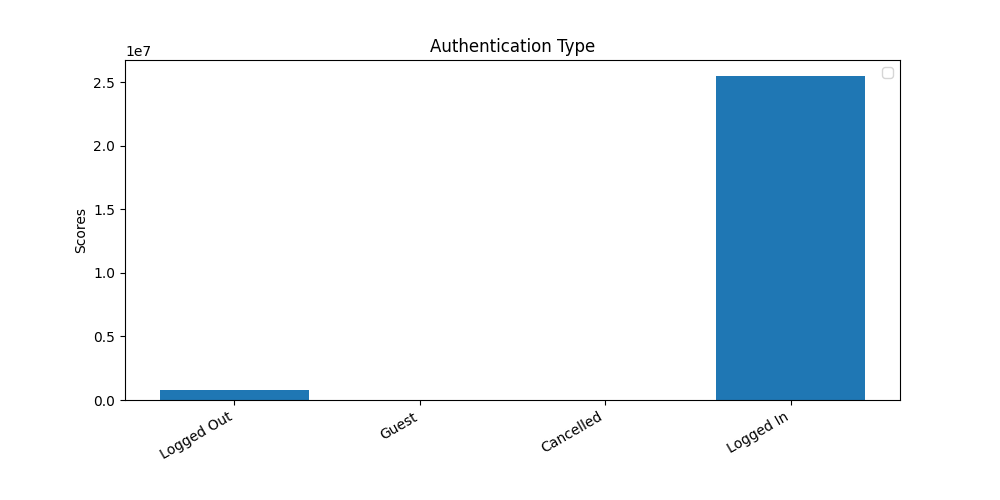

In [21]:
# Explore the auth column
auth_df = df.groupby('auth').count().toPandas()

# Plot
fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(auth_df['auth'], auth_df['count'])
ax.set_ylabel('Scores')
ax.set_title('Authentication Type')
ax.legend()
fig.autofmt_xdate()

plt.show()

%matplot plt

In [22]:
# 'Cancelled' category corresponds to 'Cancellation Confirmation' in the page column.

df.where(df.auth == 'Cancelled').select(['userId', 'tsDate', 'sessionId', 'auth', 'page']).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+---------+---------+--------------------+
| userId|             tsDate|sessionId|     auth|                page|
+-------+-------------------+---------+---------+--------------------+
|1768454|2018-10-01 02:15:45|    24588|Cancelled|Cancellation Conf...|
|1381915|2018-10-01 03:02:56|     4031|Cancelled|Cancellation Conf...|
|1298443|2018-10-01 03:53:28|    21329|Cancelled|Cancellation Conf...|
|1379352|2018-10-01 05:19:04|    14061|Cancelled|Cancellation Conf...|
|1068112|2018-10-01 05:26:07|    22282|Cancelled|Cancellation Conf...|
+-------+-------------------+---------+---------+--------------------+
only showing top 5 rows

_'Cancelled'_ category corresponds to _'Cancellation Confirmation'_ in the page column.

In [23]:
print("Number of sessionId is {}".format(df.select('sessionId').dropDuplicates().count()))
print("Number of missing values in the sessionId column is {}".format(df.where(df.sessionId.isNull()).count()))
print("Number of empty values in the sessionId column is {}".format(df.where(df.sessionId == "").count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of sessionId is 228713
Number of missing values in the sessionId column is 0
Number of empty values in the sessionId column is 0

In [24]:
# explore maximum and minimum session length 

sessions_df = df.where(df.userId != "").groupby(['userId','sessionId']).agg(((Fmax('ts') - Fmin('ts'))/1000).alias('sessionlength'))

sessions_df.sort('sessionlength', ascending = False).show(5)
sessions_df.where(sessions_df.sessionlength != 0).sort('sessionlength', ascending = True).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+-------------+
| userId|sessionId|sessionlength|
+-------+---------+-------------+
|1261737|    20025|    5244379.0|
|1261737|    20053|    5243248.0|
|1261737|    19352|    5235133.0|
|1261737|    25702|    5233265.0|
|1261737|    24546|    5223551.0|
+-------+---------+-------------+
only showing top 5 rows

+-------+---------+-------------+
| userId|sessionId|sessionlength|
+-------+---------+-------------+
|1261737|    31891|          1.0|
|1261737|    20419|          1.0|
|1261737|    27246|          1.0|
|1261737|    32149|          1.0|
|1261737|    35652|          1.0|
+-------+---------+-------------+
only showing top 5 rows

The maximum session length is more then 74 hours, The minimum session length is 1 sec (excluding zero).

#### 3. Song-level information

Information related to the song that is currently playing.

In [25]:
# Song-level information
df.select(['artist', 'song', 'length']).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------+
|              artist|                song|    length|
+--------------------+--------------------+----------+
|           Popol Vuh|Ich mache einen S...| 524.32934|
|         Los Bunkers|         MiÃÂ©ntele| 238.39302|
|                Lush|           Baby Talk| 140.35546|
|Barry Tuckwell/Ac...|Horn Concerto No....| 277.15873|
|                 Yes|Close To The Edge...|1121.25342|
+--------------------+--------------------+----------+
only showing top 5 rows

In [26]:
# number of listen songs
df.where(df.page == 'NextSong').groupby('page').count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------+
|    page|   count|
+--------+--------+
|NextSong|20850271|
+--------+--------+

In [27]:
print("Number of different artists is {}".format(df.where(df.artist.isNotNull()).select('artist').dropDuplicates().count()))
print("Number of different song names is {}".format(df.where(df.song.isNotNull()).select('song').dropDuplicates().count()))
print("Number of songs in dataset (including full duplicates) is {}".format(df.select(['artist','song','length']).dropDuplicates().count()))
print("Number of songs in dataset (including duplicates with same artist and song name) is {}".format(df.select(['artist','song']).dropDuplicates().count()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of different artists is 38337
Number of different song names is 253564
Number of songs in dataset (including full duplicates) is 314336
Number of songs in dataset (including duplicates with same artist and song name) is 311149

## Exploratory data analysis

Let's do some exploratory data analysis to observe the behavior of users who stayed and users who left. We'll start by looking at the aggregate metrics for these two groups of users, observing how many specific actions they have experienced in a given unit of time or the number of songs played.

In [28]:
# Drop missing userId and sessionId
df = df.dropna(how = 'any', subset = ['userId','sessionId'])
df = df[df.userId != ""]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
# add downgrade flag
df = df.withColumn('downgrade', when(df.page == 'Submit Downgrade', 1).otherwise(0))
df = df.withColumn('user_downgrade', Fmax('downgrade').over(Window.partitionBy('UserId')))

# add churn
df = df.withColumn('churn', when(df.page == 'Cancellation Confirmation', 1).otherwise(0))
df = df.withColumn('user_churn', Fmax('churn').over(Window.partitionBy('UserId')))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Perhaps the target value is related to the gender of the users.

In [30]:
churn_gender_df = df.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().toPandas()
churn_gender_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   user_churn gender  count
0           1      F   2347
1           1      M   2656
2           0      F   8279
3           0      M   8995
4           0   None      1

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

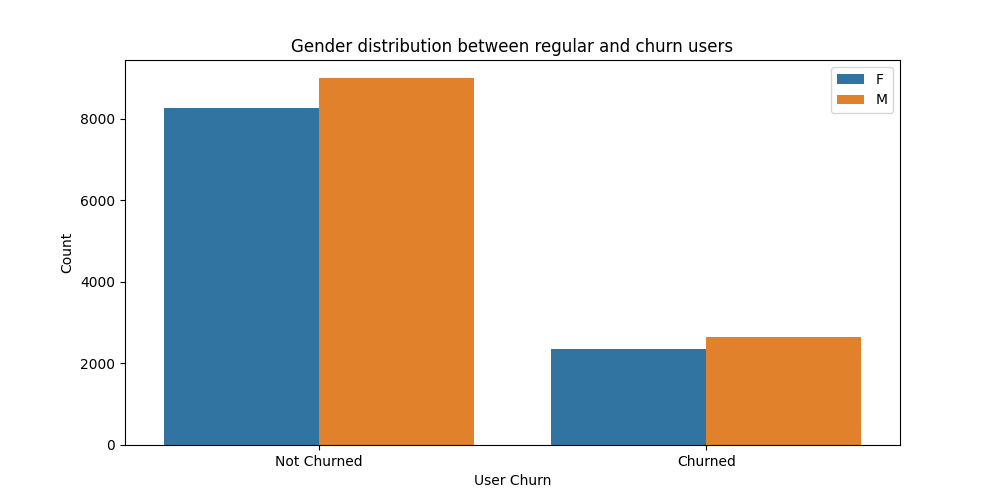

In [31]:
# Plotting a bar plot to show gender distribution between regular and churn users
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Gender distribution between regular and churn users')
ax = sns.barplot(x = 'user_churn', y = 'count', data = churn_gender_df, hue = 'gender')

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

Who cancels the service more often, paid users or free users?

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

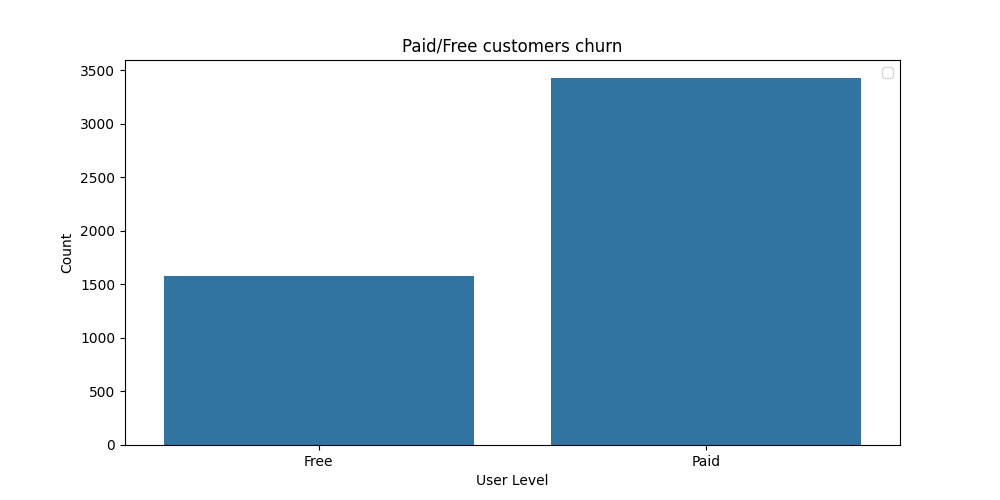

In [32]:
# Plotting a bar plot to show differense between Paid/Free customers churn
fig, ax = plt.subplots(figsize=(10, 5))

df_level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()
plt.title('Paid/Free customers churn')
sns.barplot(data = df_level_pd, x = 'level', y = 'count', color = sns.color_palette()[0])

ax.set(xticklabels=['Free', 'Paid'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level')
ax.legend()

%matplot plt

The average number of songs played by users who unsubscribed versus those who did not.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

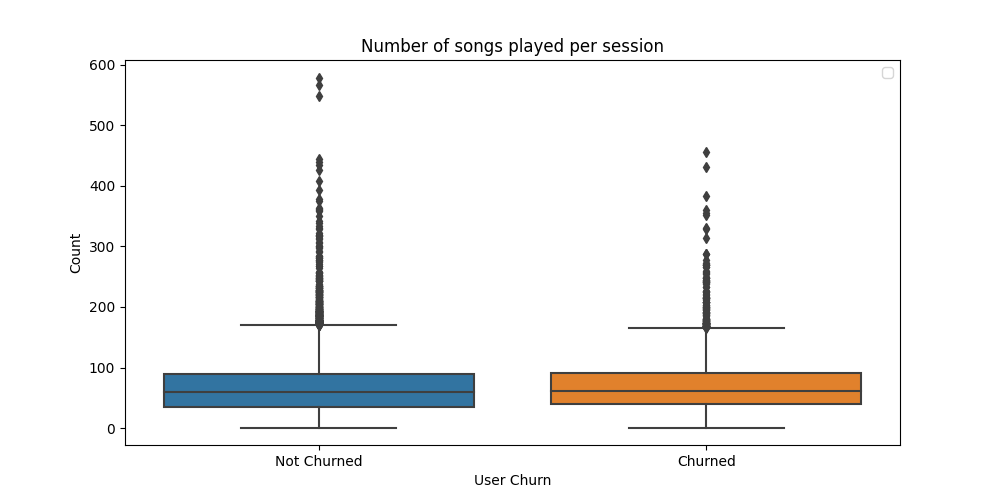

In [33]:
# Plotting Number of songs played per session

avg_songs_df = df.where(df.song.isNotNull()).groupby(['user_churn', 'userId', 'sessionId']).count()\
    .groupby(['user_churn', 'userId']).agg({'count': 'avg'}).toPandas()

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Number of songs played per session')
sns.boxplot('user_churn', y = 'avg(count)', data = avg_songs_df)

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

The average session lenght who unsubscribed versus those who did not.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

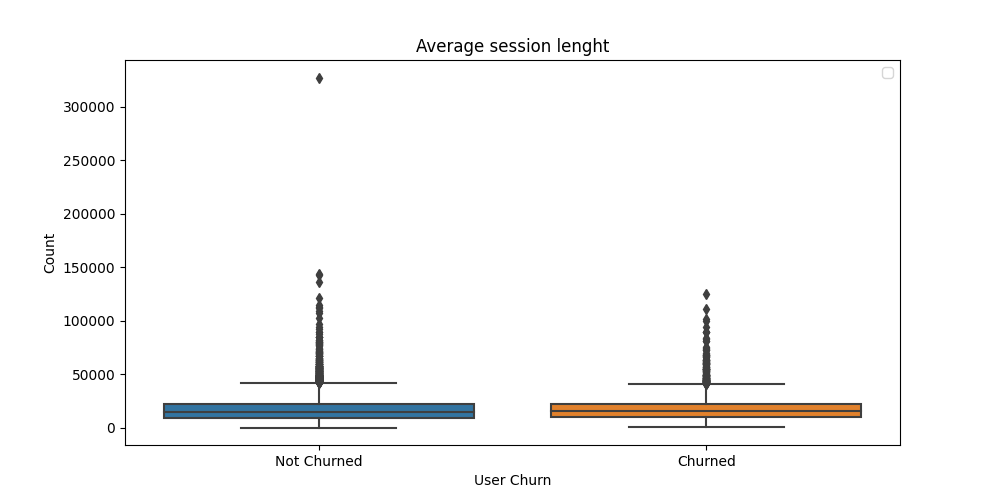

In [34]:
avg_session_df = df.groupby(['user_churn', 'userId', 'sessionId']) \
            .agg(((Fmax('ts') - Fmin('ts')) / 1000).alias('sessionlength')) \
            .groupby(['user_churn', 'userId']).agg({'sessionlength': 'avg'}).toPandas()

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Average session lenght')
sns.boxplot('user_churn', y = 'avg(sessionlength)', data = avg_session_df)

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

%matplot plt

Users who unsubscribe may not use the service for so long.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

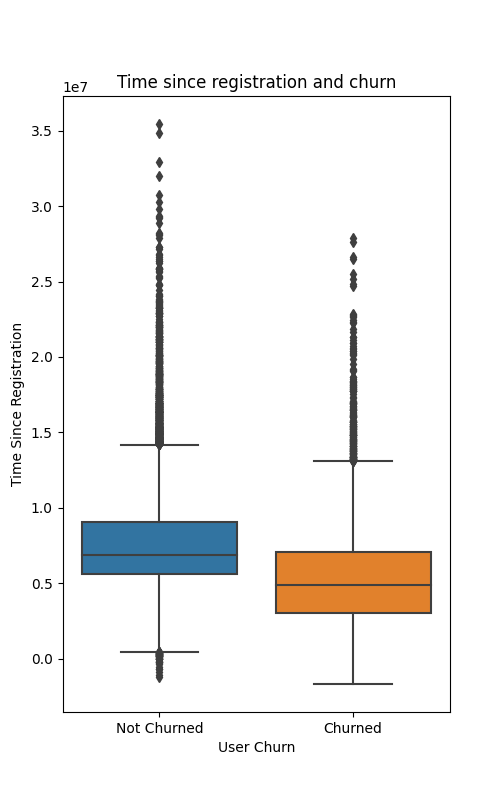

In [35]:
life_time_df = df.groupby(['user_churn', 'userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df.ts - df.registration) / 1000) \
                    .groupBy('userId', 'user_churn').agg({'life_time' : 'max'}).toPandas()

# Plottint this dataframe
fig, ax = plt.subplots(figsize=(5, 8))

sns.boxplot(data=life_time_df, x='user_churn', y='max(life_time)')
plt.xlabel('User Churn')
plt.ylabel('Time Since Registration')
plt.title('Time since registration and churn')
ax.set(xticklabels=['Not Churned', 'Churned'])

%matplot plt

How about the number of friends?

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

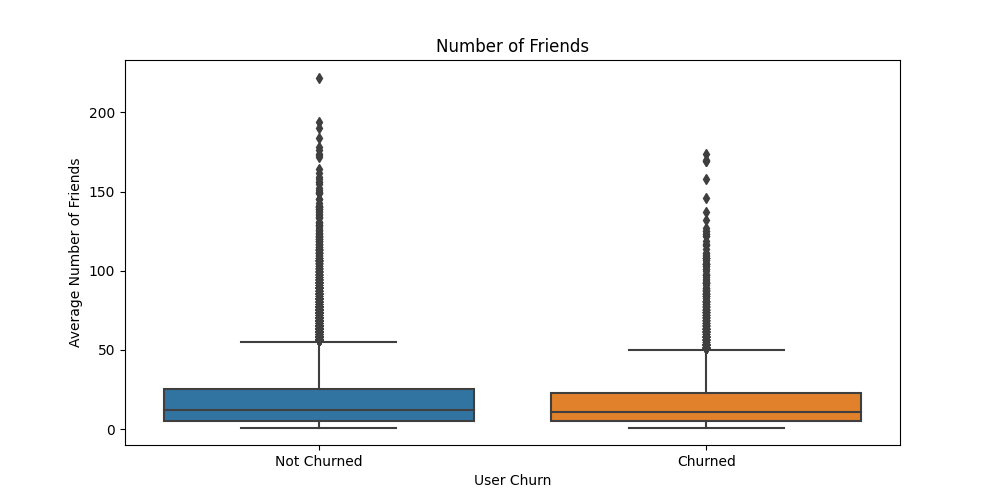

In [36]:
# dataframe whith friends
friends_df = df.where('page == "Add Friend"').groupby(['user_churn', 'userId']).count()\
                        .groupby(['user_churn', 'userId']).agg({'count': 'avg'}).toPandas()

# Plottint how Number of Friends correlations with Churn

fig, ax = plt.subplots(figsize=(10, 5))

plt.title('Number of Friends')
sns.boxplot('user_churn', y = 'avg(count)', data = friends_df)
plt.ylabel('Average Number of Friends')
plt.xlabel('User Churn')
ax.set(xticklabels=['Not Churned', 'Churned'])

%matplot plt

## Feature Engineering

Let's extract the features that will help us create the model. We need the following features:

1. Total songs listened
2. Gender
3. Number of thumbs down
4. Number of thumbs up
5. Total time since registration
6. Average songs played per session
7. Number of songs added to the playlist
8. Total number of friends
9. Help page visits 
10. Settings page visits
11. Errors
12. Downgrade
13. Paid/Free users (last label)
14. Churn (target)

In [37]:
features = []

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### 1. Total songs listened

In [38]:
songs_df = df.select('userID', 'page').where(df.page == 'Add to Playlist').groupBy('userID').count() \
                    .withColumnRenamed('count', 'songs')

songs_df.show(5)

features.append(songs_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
| userID|songs|
+-------+-----+
|1142513|   19|
|1972195|   83|
|1883991|   46|
|1816626|    6|
|1869054|   44|
+-------+-----+
only showing top 5 rows

#### 2. Gender
Set Female to 1, Male to 0

In [39]:
gender_df = df.groupby('userId').agg(first(when(col('gender') == "F", 1).otherwise(0)).alias('gender'))

gender_df.show(5)

features.append(gender_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+
| userId|gender|
+-------+------+
|1390009|     0|
|1492713|     0|
|1114507|     1|
|1338783|     1|
|1010669|     0|
+-------+------+
only showing top 5 rows

#### 3. Number of thumbs down

In [40]:
thumbs_down_df = df.select('userId', 'page').where(df.page == 'Thumbs Down').groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_down_df')

thumbs_down_df.show(5)

features.append(thumbs_down_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------+
| userId|thumbs_down_df|
+-------+--------------+
|1142513|             4|
|1972195|            35|
|1816626|             2|
|1869054|            19|
|1344069|            25|
+-------+--------------+
only showing top 5 rows

#### 4. Number of thumbs up

In [41]:
thumbs_up_df = df.select('userId', 'page').where(df.page == 'Thumbs Up').groupBy('userId').count() \
                    .withColumnRenamed('count', 'thumbs_up_df')
thumbs_up_df.show(5)

features.append(thumbs_up_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+
| userId|thumbs_up_df|
+-------+------------+
|1142513|          22|
|1271218|         250|
|1883991|          70|
|1816626|          11|
|1869054|          93|
+-------+------------+
only showing top 5 rows

#### 5. Total time since registration

In [42]:
time_since_registration_df = df.groupby(['userId', 'ts', 'registration']).count() \
                    .withColumn('life_time', (df.ts - df.registration) / 1000) \
                    .groupBy('userId').agg({'life_time' : 'max'}) \
                    .withColumnRenamed('max(life_time)', 'time_since_registration')

time_since_registration_df.show(5)

features.append(time_since_registration_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------------+
| userId|time_since_registration|
+-------+-----------------------+
|1567623|              9177633.0|
|1271218|              7515628.0|
|1142513|            1.0118609E7|
|1396135|            1.0209562E7|
|1180406|            1.5441272E7|
+-------+-----------------------+
only showing top 5 rows

#### 6. Average songs played per session

In [43]:
avg_songs_p_session_df = df.where(df.song.isNotNull()).groupby(['userId', 'sessionId']).count()\
                            .groupby(['userId']).agg({'count': 'avg'}) \
                            .withColumnRenamed('avg(count)', 'avg_songs_p_session')

avg_songs_p_session_df.show(5)

features.append(avg_songs_p_session_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+
| userId|avg_songs_p_session|
+-------+-------------------+
|1699838| 55.666666666666664|
|1380035|  74.84615384615384|
|1349958|  75.65384615384616|
|1338783|           104.5625|
|1440693|             20.875|
+-------+-------------------+
only showing top 5 rows

#### 7. Number of songs added to playlist

In [44]:
songs_in_playlist_df = df.select('userID', 'page') \
                            .where(df.page == 'Add to Playlist').groupBy('userID').count() \
                            .withColumnRenamed('count', 'songs_in_playlist')

songs_in_playlist_df.show(5)

features.append(songs_in_playlist_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
| userID|songs_in_playlist|
+-------+-----------------+
|1567623|               39|
|1271218|              137|
|1142513|               19|
|1492713|               20|
|1816626|                6|
+-------+-----------------+
only showing top 5 rows

#### 8. Total number of friends

In [45]:
number_of_friends_df = df.where('page == "Add Friend"').groupby(['userId']).count()\
                        .groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'number_of_friends')
                                                                 
number_of_friends_df.show(5)

features.append(number_of_friends_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
| userId|number_of_friends|
+-------+-----------------+
|1142513|             16.0|
|1010669|             77.0|
|1031677|              1.0|
|1883991|             18.0|
|1110773|             10.0|
+-------+-----------------+
only showing top 5 rows

#### 9. Help page visits 

In [46]:
help_df = df.groupby('userId').agg(Fsum(when(col('page') == 'Help', 1).otherwise(0)).alias('help_visits'))

help_df.show(5)

features.append(help_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------+
| userId|help_visits|
+-------+-----------+
|1567623|          5|
|1271218|         27|
|1142513|          4|
|1492713|          5|
|1010669|         14|
+-------+-----------+
only showing top 5 rows

#### 10. Settings page visits

In [47]:
settings_df = df.groupby('userId').agg(Fsum(when(col('page') == 'Settings', 1).otherwise(0)).alias('settings_visits'))

settings_df.show(5)

features.append(settings_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+
| userId|settings_visits|
+-------+---------------+
|1142513|              4|
|1492713|              3|
|1396135|              7|
|1271218|             24|
|1972195|             22|
+-------+---------------+
only showing top 5 rows

#### 11. Errors

In [48]:
errors_df = df.groupby('userId').agg(Fsum(when(col('page') == 'Error', 1).otherwise(0)).alias('errors'))

errors_df.show(5)

features.append(errors_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------+
| userId|errors|
+-------+------+
|1142513|     1|
|1492713|     0|
|1396135|     0|
|1271218|     6|
|1972195|     2|
+-------+------+
only showing top 5 rows

#### 12. Downgrade

In [49]:
downgrade_df = df.select('userId', 'downgrade').dropDuplicates()

downgrade_df.show(5)

features.append(downgrade_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+
| userId|downgrade|
+-------+---------+
|1892796|        0|
|1520845|        0|
|1101016|        0|
|1484091|        0|
|1790654|        0|
+-------+---------+
only showing top 5 rows

#### 13. Paid/Free users (last)

Set paid users to 1, free to 0

In [50]:
level_df = df.groupby('userId').agg(last(when(col('level') == 'paid', 1).otherwise(0)).alias('level'))

level_df.show(5)

features.append(level_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
| userId|level|
+-------+-----+
|1567623|    1|
|1271218|    1|
|1142513|    0|
|1492713|    0|
|1010669|    1|
+-------+-----+
only showing top 5 rows

#### 14. Churn (target)

In [51]:
churn = df.select('userId', 'user_churn').dropDuplicates()

churn.show(5)

features.append(churn)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+
| userId|user_churn|
+-------+----------+
|1001393|         0|
|1002143|         0|
|1002493|         1|
|1002749|         0|
|1004060|         0|
+-------+----------+
only showing top 5 rows

In [52]:
print(features)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[DataFrame[userID: string, songs: bigint], DataFrame[userId: string, gender: int], DataFrame[userId: string, thumbs_down_df: bigint], DataFrame[userId: string, thumbs_up_df: bigint], DataFrame[userId: string, time_since_registration: double], DataFrame[userId: string, avg_songs_p_session: double], DataFrame[userID: string, songs_in_playlist: bigint], DataFrame[userId: string, number_of_friends: double], DataFrame[userId: string, help_visits: bigint], DataFrame[userId: string, settings_visits: bigint], DataFrame[userId: string, errors: bigint], DataFrame[userId: string, downgrade: int], DataFrame[userId: string, level: int], DataFrame[userId: string, user_churn: int]]

In [53]:
final_df = songs_df

def merging_dataframes(a_df, b_df):
    '''  
    INPUT: 
    df1, df2 - dataframes to be merged
    
    OUTPUT: 
    df - merged dataframe
    
    Description: 
    Join dataframes
    '''
    
    merged_df = b_df.join(a_df, on=['userId'], how='left')
    
    return merged_df

for names in features[1:]:
    final_df = merging_dataframes(final_df, names)

# fill nans
final_df = final_df.na.fill(0)
final_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+----------+-----+---------+------+---------------+-----------+-----------------+-----------------+-------------------+-----------------------+------------+--------------+------+-----+
| userId|user_churn|level|downgrade|errors|settings_visits|help_visits|number_of_friends|songs_in_playlist|avg_songs_p_session|time_since_registration|thumbs_up_df|thumbs_down_df|gender|songs|
+-------+----------+-----+---------+------+---------------+-----------+-----------------+-----------------+-------------------+-----------------------+------------+--------------+------+-----+
|1001393|         0|    1|        0|     1|              8|          6|             11.0|               18|  70.57142857142857|              5173895.0|          43|             6|     0|   18|
|1002143|         0|    1|        0|     0|              4|          4|             14.0|               10|             44.875|              6874233.0|          24|             5|     0|   10|
|1002493|         1|    0|        0

In [54]:
final_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- user_churn: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- errors: long (nullable = true)
 |-- settings_visits: long (nullable = true)
 |-- help_visits: long (nullable = true)
 |-- number_of_friends: double (nullable = false)
 |-- songs_in_playlist: long (nullable = true)
 |-- avg_songs_p_session: double (nullable = false)
 |-- time_since_registration: double (nullable = false)
 |-- thumbs_up_df: long (nullable = true)
 |-- thumbs_down_df: long (nullable = true)
 |-- gender: integer (nullable = true)
 |-- songs: long (nullable = true)

## Modeling

Let's split the dataset into training, test, and validation sets. Let's test several machine learning methods. We will evaluate the accuracy of various models, adjusting the parameters if necessary.

#### Vectorize and Standardizing 

Let's transform numeric features to Vector Assembler.

In [55]:
final_df.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['userId', 'user_churn', 'level', 'downgrade', 'errors', 'settings_visits', 'help_visits', 'number_of_friends', 'songs_in_playlist', 'avg_songs_p_session', 'time_since_registration', 'thumbs_up_df', 'thumbs_down_df', 'gender', 'songs']

In [56]:
# Let's transform numeric features to Vector Assembler
num_vector = VectorAssembler(inputCols=['downgrade', 'errors', 'settings_visits', 
                                        'help_visits', 'number_of_friends', 'songs_in_playlist', 
                                        'avg_songs_p_session', 'time_since_registration', 'thumbs_up_df', 
                                        'thumbs_down_df', 'songs','level', 'gender'], 
                             outputCol='num_vector_assem')

num_scaler = StandardScaler(inputCol='num_vector_assem', outputCol ='num_vector_sc', withStd=True, withMean=True)

final_vector = VectorAssembler(inputCols=['level', 'gender']+['num_vector_sc'], 
                               outputCol='features_vector')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
data = num_vector.transform(final_df)

feature_standardize = num_scaler.fit(data)
data = feature_standardize.transform(data)

data = final_vector.transform(data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [58]:
data = data.select(data.user_churn, data.features_vector)
data.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+
|user_churn|     features_vector|
+----------+--------------------+
|         0|[1.0,0.0,-0.47859...|
|         0|[1.0,0.0,-0.47859...|
|         1|[1.0,0.0,2.089379...|
|         1|[1.0,0.0,-0.47859...|
|         0|[1.0,0.0,-0.47859...|
+----------+--------------------+
only showing top 5 rows

In [59]:
# Split Test and Train set
train, test = data.randomSplit([0.6, 0.4], seed=42)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Baseline Model

We will train three models: Random Forest, Gradient Boosted Trees, and Support Vector Machine. But before we need baseline model. A baseline is the result of a very basic model/solution. Then we will try to make more complex solutions in order to get a better result. If we achieve a better score than the baseline, it is good.

We will try to assume that the answer is always zero (No user has canceled their subscription.). This will be our baseline model.

In [60]:
#baseline model
baseline = test.withColumn('prediction', lit(0.0))
baseline.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+----------+
|user_churn|     features_vector|prediction|
+----------+--------------------+----------+
|         0|[0.0,0.0,-0.47859...|       0.0|
|         0|[0.0,0.0,-0.47859...|       0.0|
|         0|[0.0,0.0,-0.47859...|       0.0|
|         0|[0.0,0.0,-0.47859...|       0.0|
|         0|[0.0,0.0,-0.47859...|       0.0|
+----------+--------------------+----------+
only showing top 5 rows

In [61]:
# function for printing results
def evaluate_print(model_result, model_name, start, end):
    ''' 
    INPUT:
    model_result - result
    model_name - string
    start, end - training time start and end
    
    OUTPUT: None
    
    Description:
    The function prints results and total time of the training
    
    '''
    
    evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
    evaluator.setLabelCol('user_churn')
    accuracy = evaluator.evaluate(model_result, {evaluator.metricName : 'accuracy'})
    f1 = evaluator.evaluate(model_result, {evaluator.metricName : 'f1'})
    time = (end - start)/60
    
    print('{} performance metrics:'.format(model_name))
    print('Accuracy: {}'.format(accuracy))
    print('F-1 Score: {}'.format(f1))
    print('Total training time: {} minutes'.format(time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
#print baseline model
evaluate_print(baseline, 'Baseline', 0, 0)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Baseline performance metrics:
Accuracy: 0.7731016381572993
F-1 Score: 0.6741701999019601
Total training time: 0.0 minutes

### Random Forest

In [63]:
numFolds = 3
rf = RandomForestClassifier(labelCol='user_churn', featuresCol='features_vector', seed = 42)
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[rf])
rf_paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10,20])
             .addGrid(rf.maxDepth, [10,20])
             .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

rf_start = time.time()
rf_model = crossval.fit(train)
rf_end = time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-63:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 1475



We are ignoring KeyError, it doesn't seem to affect the end result:

https://stackoverflow.com/questions/58910023/keyerror-when-training-a-model-with-pyspark-ml-on-aws-emr-with-data-from-s3-buck

In [64]:
rf_results = rf_model.transform(test)

evaluate_print(rf_results, 'Random Forest', rf_start, rf_end)

best_param = list(rf_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best number of trees {}, best depth {}'.format(best_param[0], best_param[1]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest performance metrics:
Accuracy: 0.872115123540592
F-1 Score: 0.8571534809089294
Total training time: 48.5243045091629 minutes
Best number of trees 20, best depth 20

### Gradient Boosted Trees

In [65]:
numFolds = 3
gbt = GBTClassifier(labelCol='user_churn', featuresCol='features_vector', seed = 42)
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[gbt])
gbt_paramGrid = (ParamGridBuilder()
                 .addGrid(gbt.maxIter, [10, 20])
                 .addGrid(gbt.maxDepth, [10, 20])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=gbt_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

gbt_start = time.time()
gbt_model = crossval.fit(train)
gbt_end = time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-65:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 6382



In [66]:
gbt_results = gbt_model.transform(test)

evaluate_print(gbt_results, 'Gradient Boosted Trees', gbt_start, gbt_end)

best_param = list(gbt_model.getEstimatorParamMaps()[np.argmax(rf_model.avgMetrics)].values())
print('Best number of iterations {}, best depth {}'.format(best_param[0], best_param[1]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Random Forest performance metrics:
Accuracy: 0.8488551000090506
F-1 Score: 0.8503837313597932
Total training time: 161.23376212914783 minutes
Best number of iterations 20, best depth 20

### Support Vector Machine

In [67]:
numFolds = 3
svc = LinearSVC(labelCol='user_churn', featuresCol='features_vector')
evaluator = MulticlassClassificationEvaluator(labelCol='user_churn')

pipeline = Pipeline(stages=[svc])
svc_paramGrid = (ParamGridBuilder()
                 .addGrid(svc.maxIter, [10, 20])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_paramGrid,
    evaluator=evaluator,
    numFolds=numFolds)

svc_start = time.time()
svc_model = crossval.fit(train)
svc_end = time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-67:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 73479



In [68]:
svc_results = svc_model.transform(test)

evaluate_print(svc_results, "Support Vector Machine", svc_start, svc_end)
best_param = list(svc_model.getEstimatorParamMaps()[np.argmax(svc_model.avgMetrics)].values())
print('Best number of iterations {}'.format(best_param[0]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Support Vector Machine performance metrics:
Accuracy: 0.7731016381572993
F-1 Score: 0.6741701999019601
Total training time: 39.79981347322464 minutes
Best number of iterations 10

## Evaluate models

##### Performance ranking:

1. Random Forest has F1 score 0.857, Accuracy 0.872
2. Gradient Boosted Trees has F1 score 0.850, Accuracy 0.848
3. Support Vector Machine has F1 score of 0.674, Accuracy 0.773

As we optimized based on F1, Random Forest is the best model.

## Summary and Future Improvement

In this project, I was able to study the Sparkify service dataset and create functions for the modeling process. To begin with, we studied different levels of the dataset, which was the logs of each user session. The dataset allowed me to study churn and create suitable predictive features. I trained three models: Random Forest, Gradient Boosted Trees, and Support Vector Machine. Random Forest proved to be the best and can be used in the future.
The main complications that occurred during the coding process were the configuration of the AWS cluster when working with big data. The default gives not enough memory and too little timeout. How I fixed this is written at the beginning of the article.

In addition, feature selection was not a trivial task. In the end, I chose a set of 9 features presented above (including the target one).

In the future, the model can be improved if we have more data on user behavior or about songs.